In [81]:
import arviz as az
import constants as c
import folium
import geopandas as gpd
import jax.numpy as jnp
import jax
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import numpyro
import numpyro.distributions as dist
import os
import pandas as pd
import pickle
import scipy
import seaborn as sns

from matplotlib.gridspec import GridSpec

from numpyro.infer.initialization import init_to_value
from numpyro.infer     import MCMC, NUTS, SVI, Trace_ELBO, autoguide

from submodels import build_bym, build_factor, build_spline, build_grw, build_interaction

# Check to make sure Jax install isn't broken
_ = jnp.ones((2,))
jax.devices()

# Use standard matplotlib style
plt.style.use('default')

import scienceplots
plt.style.use(['science', 'no-latex'])

visuals_dir = os.path.join(c.ROOT_DIR, 'visuals')



ModuleNotFoundError: No module named 'geopandas'

# Loading data

In [2]:
policy_filepath = os.path.join(c.DATA_DIR, 'brvehins', 'brvehins_clean.parquet')
df = pd.read_parquet(policy_filepath)

city_filepath = os.path.join(c.DATA_DIR, 'brvehins', 'br_city_lat_long.parquet')
city_df       = pd.read_parquet(city_filepath)

covariates_filepath = os.path.join(c.DATA_DIR, 'brvehins', 'ee_covariates.parquet')
covariates_df = pd.read_parquet(covariates_filepath)

graph_filepath = os.path.join(c.DATA_DIR, 'brvehins', 'city_graph.npz')
geo_graph      = scipy.sparse.load_npz(graph_filepath) 

assert df['city_idx'].max() == geo_graph.shape[0] - 1

covariate_cols = [
    'Water', 'Vegetation','Elevation','Topography','Forest','Motorized travel','Nonmotorized travel','Rainfall','Log10 population'
]




# Running model

In [3]:
RNG_SEED = 19910827

inference_method = 'mcmc'

mcmc_kwargs = dict(num_warmup=2000, num_samples=2000, num_chains=2, thinning=20)
svi_iters   = 200_000
adam_lr     = 0.001

factor_indices = {
    'brand': df['VehBrand'].cat.codes.values,
    'category': df['VehCategory'].cat.codes.values,
}

interaction_indices = None

# Standardize the covariates to have mean 0 and std 1
geo_covariates = covariates_df[covariate_cols] \
    .apply(lambda x: (x - x.mean()) / x.std(), axis=0) \
    .values
    


# Model definition

In [4]:
def model(geo_idx, 
    factor_indices, 
    interaction_indices, 
    exposure, 
    counts, 
    times, 
    geo_adj_matrix=None, 
    k=None, 
    spline_exposure=True, 
    n_spline_knots=6, 
    spline_degree=3,
    geo_covariates=None):
    '''
    Sets up the NumPyro model for a Poisson regression with log link function and multiple modeling components for spatial, temporal, and categorical effects.
    Also includes a nonlinear spline adjustment to the log exposure to allow for a nonlinear exposure-risk relationship.
    '''

    log_exposure = numpyro.deterministic('log_exposure', np.log10(exposure))

    # Make sure all counts are nonnegative and finite
    assert np.all(counts >= 0)
    assert np.all(np.isfinite(counts))

    # We start with only the bare log exposure values
    summands = [log_exposure]
    
    geo_effect  = build_bym(geo_idx, geo_adj_matrix=geo_adj_matrix, geo_covariates=geo_covariates)
    summands += [geo_effect[geo_idx]]
    
    for name, idx in factor_indices.items():
        summands += [build_factor(idx, name)]

    summands += [build_grw(times)]

    # Represent interaction atrix as output of low-rank matrix factorization
    # with k factors. Note that we required the factors for any interactions
    # already be present in the factor_indices dict; else, we would have
    # interactions without main effect which would not be a good idea.
    if interaction_indices is not None:
        for idx1_name, idx2_name in interaction_indices:
            summands += [build_interaction(factor_indices[idx1_name], factor_indices[idx2_name], k)]

    # Allow for a spline-based adjustment to the log exposure to indicate if the exposure-risk relationship
    # is not quite linear. The basic idea is that we want to use priors to encourage the spline to be equal to the zero function
    # and add it to the log exposure. We can then use the spline coefficients as a measure of how much the exposure-risk relationship
    # deviates from linearity.
    if spline_exposure:
        summands += [build_spline(log_exposure, n_spline_knots, spline_degree)]

    lam = numpyro.deterministic('lam', jnp.exp(sum(summands)))

    # Poisson likelihood
    with numpyro.plate('data', len(geo_idx)):
        numpyro.sample('obs', dist.Poisson(lam), obs=counts)


# Model execution

In [5]:
rng_key = jax.random.PRNGKey(RNG_SEED)
rng_key, rng_key_ = jax.random.split(rng_key)

model_kwargs = dict(
    geo_idx=df['city_idx'].values,
    factor_indices=factor_indices,
    interaction_indices=None,
    exposure=df['ExposTotal'].values,
    counts=df['ClaimNbColl'].values,
    times=df['VehYearSince1971'].values,
    geo_adj_matrix=geo_graph,
    k=None,
    geo_covariates=geo_covariates,
    spline_exposure=True,
)


# We initialize using SVI posterior mean
# as starting point for sampling with MCMC
guide     = autoguide.AutoDiagonalNormal(model)
optimizer = numpyro.optim.Adam(adam_lr)
svi       = SVI(model, guide, optimizer, Trace_ELBO())

svi_results = svi.run(jax.random.PRNGKey(1), svi_iters, **model_kwargs)
params      = svi_results.params
trace_svi   = guide.sample_posterior(rng_key, params, sample_shape = (100,))
svi_mean_starting_point = {k: np.mean(v, axis=0) for k, v in trace_svi.items()}

# For freeing up any variables on the GPU
del guide, optimizer, svi, svi_results, params, trace_svi

# Run MCMC
nuts_kernel = NUTS(model, init_strategy=init_to_value(values=svi_mean_starting_point))
mcmc        = MCMC(nuts_kernel, **mcmc_kwargs)
mcmc.run(rng_key_, **model_kwargs)

trace           = mcmc.get_samples(group_by_chain=True)
parameter_names = list(mcmc.last_state[1].keys())

# Cast all items in dict to numpy type so we
# don't need to worry about jax/numpyro compatibility
trace = {k: np.array(v, dtype='float32') for k, v in trace.items()}

with open(os.path.join(c.DATA_DIR, 'brvehins', 'trace.pkl'), 'wb') as f:
    pickle.dump(trace, f)

100%|██████████| 200000/200000 [18:41<00:00, 178.32it/s, init loss: 49374662656.0000, avg. loss [190001-200000]: 721409.5000]
/tmp/ipykernel_3690291/1423113301.py:34: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc        = MCMC(nuts_kernel, **mcmc_kwargs)
sample: 100%|██████████| 4000/4000 [3:09:08<00:00,  2.84s/it, 511 steps of size 1.19e-02. acc. prob=0.91]   


### Calculate MCMC diagnostics

In [10]:
load_trace_from_disk = True

if load_trace_from_disk:
    with open(os.path.join(c.DATA_DIR, 'brvehins', 'trace.pkl'), 'rb') as f:
        trace = pickle.load(f)

if inference_method == 'mcmc':
    
    az_trace = az.convert_to_inference_data(trace)
    rhats = az.rhat(az_trace, var_names=parameter_names)

    # For each of the variables in the xarray.Dataset, get the highest R-hat value
    for var_name in rhats.data_vars:
        max_rhat = rhats[var_name].max().values
        if max_rhat > 1.01:
            print(f"Highest R-hat for {var_name} is {max_rhat:.2f}")

    # Output of this is an xarray with effective sample sizes
    # for each variable
    ss = az.ess(az_trace, var_names=parameter_names)

    # Print lowest ESS per variable
    for var_name in ss.data_vars:
        min_ess = ss[var_name].min().values
        if min_ess < 100:
            print(f"Lowest ESS for {var_name} is {min_ess:.2f}")
else:
    print("No diagnostics for SVI")

Highest R-hat for brand_effect is 1.02
Highest R-hat for geo_coefs is 1.02
Highest R-hat for geo_effect_car is 1.07
Highest R-hat for geo_effect_ind is 1.07
Highest R-hat for geo_effect_scale is 1.04
Highest R-hat for grw is 1.02
Highest R-hat for mixing_ratio is 1.06
Highest R-hat for rho is 1.03
Highest R-hat for sigma_brand is 1.03
Highest R-hat for spline_coefs is 1.02
Lowest ESS for geo_effect_car is 36.20
Lowest ESS for geo_effect_ind is 41.02
Lowest ESS for geo_effect_scale is 38.11
Lowest ESS for mixing_ratio is 32.43
Lowest ESS for rho is 70.93
Lowest ESS for spline_coefs is 93.95


# Examining results

## Plots

### True vs predicted

In [16]:
# For each of the items in the trace, collapse the first
# two dimensions (chain and draw) into one dimension

if len(trace['lam'].shape) == 3:
    for k, v in trace.items():
        trace[k] = v.reshape((-1, *v.shape[2:]))

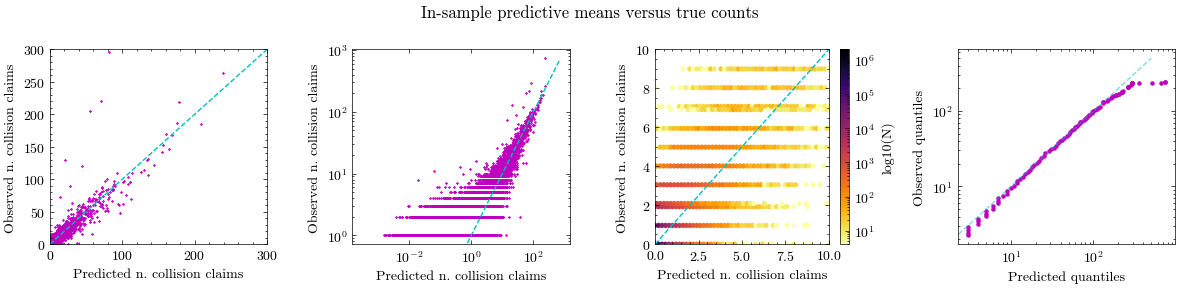

In [63]:
lam_mean = trace['lam'].mean(axis=0)

true_values = df['ClaimNbColl'].values
fig, axes = plt.subplots(1,4, figsize=(12,3))
axes = axes.ravel()

plt.suptitle("In-sample predictive means versus true counts")

plt.sca(axes[0])
plt.scatter(lam_mean, true_values, s=0.1, c='m')
plt.xlim(0,300), plt.ylim(0,300)
plt.plot(np.linspace(0,300), np.linspace(0,300), color='c',linestyle='--', label="1-1 line")
plt.ylabel("Observed n. collision claims"), plt.xlabel("Predicted n. collision claims")

# Annotate with mean absolute error and median absolute error, rounded to 1 digit
mae = np.mean(np.abs(lam_mean - true_values))

plt.text(0.05, 0.95, f"$MAE = {mae:.3f}$", transform=axes[0].transAxes, ha='left', va='top', fontsize=10, color='w', fontweight='bold')

# Same figure, but with both axes in log space
plt.sca(axes[1])
plt.scatter(lam_mean, true_values, s=0.1, c='m')
plt.plot(np.linspace(0,700), np.linspace(0,700), color='c',linestyle='--', label="1-1 line")
plt.ylabel("Observed n. collision claims"), plt.xlabel("Predicted n. collision claims")
plt.xscale('log'), plt.yscale('log')

# Hexbin plot for low counts
max_shown = 10
plt.sca(axes[2])
is_pred_in_range = (lam_mean < max_shown) & (true_values < max_shown)
plt.hexbin(lam_mean[is_pred_in_range], true_values[is_pred_in_range], gridsize=50, cmap='inferno_r', bins='log')
plt.plot(np.linspace(0,max_shown), np.linspace(0,max_shown), color='c',linestyle='--', label="1-1 line")
plt.ylabel("Observed n. collision claims"), plt.xlabel("Predicted n. collision claims")
plt.ylim(0,max_shown), plt.xlim(0,max_shown)
plt.colorbar(label="log10(N)")

# Q-Q plot for full range of data
plt.sca(axes[3])
quantiles = 1. - np.logspace(-6, -2, 100)
true_qs = np.percentile(true_values, quantiles*100)
pred_qs = np.percentile(lam_mean, quantiles*100)

plt.scatter(true_qs, pred_qs, c='m', s=5)
plt.plot(np.linspace(0,500), np.linspace(0,500), color='c',linestyle='--', label="1-1 line", alpha=0.5)
plt.ylabel("Observed quantiles"), plt.xlabel("Predicted quantiles")
plt.yscale('log'), plt.xscale('log')

# Add (A), (B)... to lower right corner of each subplot
for i, ax in enumerate(axes):
    ax.text(0.95, 0.05, f"({chr(ord('A') + i)})", transform=ax.transAxes, ha='right', va='bottom', fontsize=14, color='w', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(visuals_dir, 'brvehins-predictive.png'), dpi=300)

### Spline plot

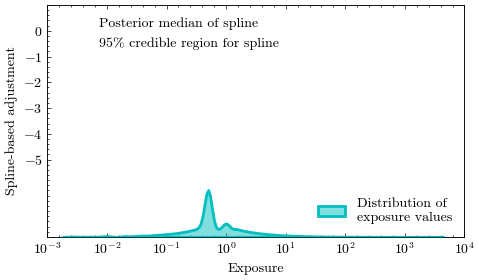

In [64]:
plt.figure(figsize=(5,3))

# Plot the median / 5% / 95% quantiles of the spline
qs = np.quantile(trace['spline'], [0.025, 0.5, 0.975], axis=0)

xs = np.quantile(np.log10(df['ExposTotal']), np.linspace(0, 1, 100))
plt.plot(xs, qs[1], color='white', label="Posterior median of spline")
plt.fill_between(xs, qs[0], qs[2], color='white', alpha=0.5, label="95% credible region for spline")

plt.xlabel("Exposure"), plt.ylabel("Spline-based adjustment")

plt.legend(loc='upper left', frameon=False)
plt.xlim([-3, 4])

plt.ylim(-8, 1)

# Only add yticks from -5 to 0
plt.yticks(np.arange(-5, 1, 1))

# Replace xticks with 10^x
plt.xticks(np.arange(-3, 5, 1), [f"$10^{{{x}}}$" for x in np.arange(-3, 5, 1)])

# On existing x-axis, make a KDE for the distribution of the log10 exposure values
# across all rows of df['ExposTotal']
# This should go on a twin axis with different ylimits. We want the KDE to only take up 1/5 of the height
# so we can see the spline
xs = np.log10(df['ExposTotal'].values)
twinx = plt.gca().twinx()
sns.kdeplot(xs, ax=twinx, color='c', alpha=0.5, linewidth=2, fill=True, label="Distribution of\nexposure values", bw_adjust=2)
twinx.set_yticks([])
twinx.set_ylim([0, 12])

# Hide ylabel on twinx
twinx.set_ylabel('')
plt.legend(loc='lower right', frameon=False)
plt.tight_layout()

plt.savefig(os.path.join(visuals_dir, 'brvehins-spline.png'), dpi=300, bbox_inches='tight', transparent=True)

## Plot of per-brand and per-category effects

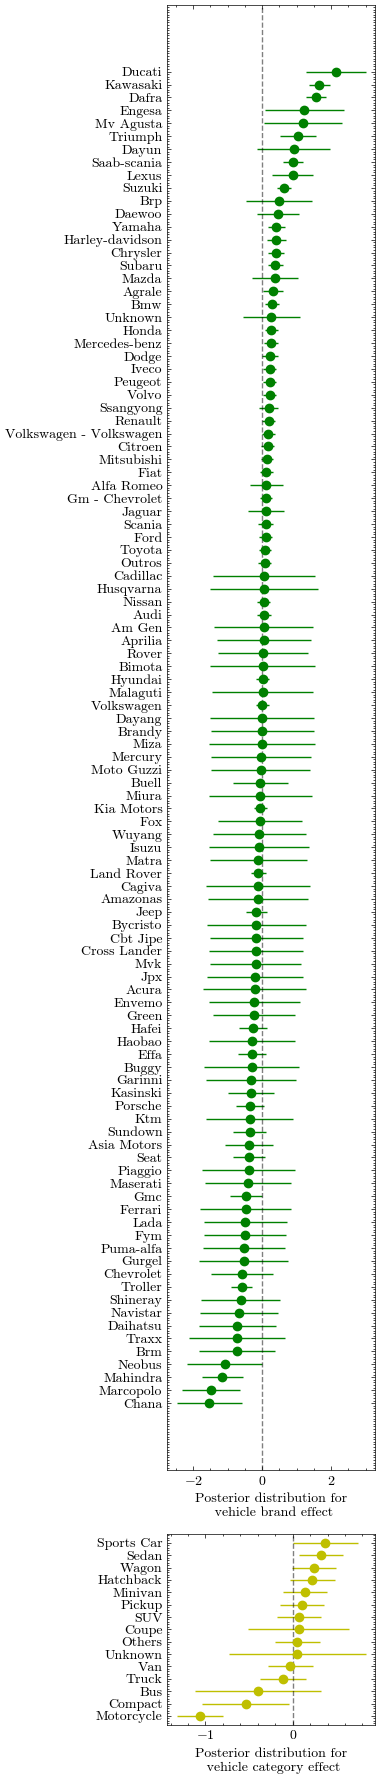

In [77]:
# Create a gridspec which is 4 high
# First row is for the category plot
# and the 2nd through 4th rows are for the brand plot

fig = plt.figure(figsize=(4, 18))
gs = GridSpec(7, 1, figure=fig)

# Create the axes for the category plot
# and brand plot
axes = [fig.add_subplot(gs[0:6, 0]), fig.add_subplot(gs[6, 0])]

brand_effect = trace['brand_effect'].mean(axis=0)
brand_effect_std = trace['brand_effect'].std(axis=0)

# Sort the brands by the estimated effect and plot 2 sigma error bars
brand_df = pd.DataFrame({'brand': df['VehBrand'].cat.categories, 'effect': brand_effect, 'effect_std': brand_effect_std})
brand_df = brand_df.sort_values('effect')

axes[0].errorbar(brand_df['effect'], brand_df['brand'], xerr=2*brand_df['effect_std'], fmt='o', color='g')
axes[0].axvline(0, color='k', linestyle='--', alpha=0.5)
axes[0].set_xlabel("Posterior distribution for\n vehicle brand effect")

# Add second subplot for the category plot
category_effect = trace['category_effect'].mean(axis=0)
category_effect_std = trace['category_effect'].std(axis=0)

category_df = pd.DataFrame({'category': df['VehCategory'].cat.categories, 'effect': category_effect, 'effect_std': category_effect_std})
category_df = category_df.sort_values('effect')

axes[1].errorbar(category_df['effect'], category_df['category'], xerr=2*category_df['effect_std'], fmt='o', color='y')
axes[1].axvline(0, color='k', linestyle='--', alpha=0.5)
axes[1].set_xlabel("Posterior distribution for\n vehicle category effect")

plt.tight_layout()
plt.savefig(os.path.join(visuals_dir, 'brvehins-category-brand.png'), dpi=300, bbox_inches='tight', transparent=True)

### Plot for coefficients

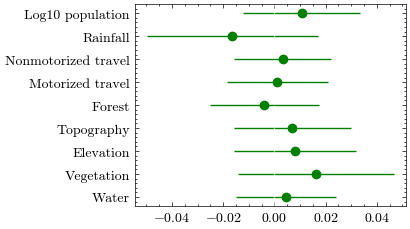

In [76]:
geo_coefs_mean = trace['geo_coefs'].mean(axis=0)
geo_coefs_std  = trace['geo_coefs'].std(axis=0)

plt.errorbar(geo_coefs_mean, covariate_cols , xerr=2*geo_coefs_std, fmt='o', color='g')
plt.axvline(0, linestyle='--', color='white', alpha=0.5)
plt.savefig(os.path.join(visuals_dir, 'brvehins-geo-coefs.png'), dpi=300, bbox_inches='tight', transparent=True)


### Map of spatial random effect

In [26]:
geo_effect     = trace['geo_effect_car'].mean(axis=0)
geo_effect_std = trace['geo_effect_car'].std(axis=0)

gdf = gpd.read_file(os.path.join(c.DATA_DIR, 'brvehins', 'city_polygons.gpkg'))

# Create a Folium map using the locations of the cities
# and the size of the geo effects to make markers
# on the map. The marker color is controlled by the effect size.
m = folium.Map(location=[-15.77972, -47.92972], zoom_start=6)

# Get colors for the markers
norm = plt.Normalize(geo_effect.min(), geo_effect.max())
cmap = plt.cm.get_cmap('coolwarm')
geo_effect_colors = cmap(norm(geo_effect))

# Map colors to hex codes
geo_effect_colors = [matplotlib.colors.rgb2hex(cmap(norm(v))) for v in geo_effect]

# Add polygons from gdf to map and color them by the geo effect
for i, row in gdf.iterrows():
    folium.GeoJson(
        row.geometry,
        style_function=lambda feature, color=geo_effect_colors[i]: {
            'fillColor': color,
            'color': color,
            'weight': 2,
            'dashArray': '5, 5',
            'fillOpacity': 0.5,
        }
    ).add_to(m)

m

/tmp/ipykernel_3690291/4327891.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('coolwarm')


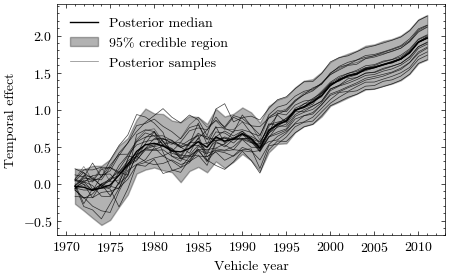

In [80]:
plt.figure(figsize=(5,3))
# Plot the median / 5% / 95% quantiles of the spline
qs = np.quantile(trace['grw'], [0.025, 0.5, 0.975], axis=0)
xs = np.arange(1971, 2012)

plt.plot(xs, qs[1], color='k', label="Posterior median")
plt.fill_between(xs, qs[0], qs[2], color='k', alpha=0.3, label="95% credible region")
plt.ylabel("Temporal effect")
plt.xlabel("Vehicle year")

# For first few samples, draw the actual trajectories
plt.plot(xs, trace['grw'][0], color='k', alpha=0.5, linewidth=0.5, label="Posterior samples")

for i in range(1, 20):
    plt.plot(xs, trace['grw'][i], color='k', alpha=0.75, linewidth=0.5)

plt.legend(loc='upper left', frameon=False)
plt.savefig(os.path.join(visuals_dir, 'brvehins-grw.png'), dpi=300, bbox_inches='tight', transparent=True)